# Kinetic energy, ocean heat content and average salinity
## Preprocessing
Load data, get cartesian coordinates, calculate time dependent volumes of cells and interpolate velocities onto rho grid.

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1

import os
import sys

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)

# import my methods, make sure they get reloded by each call
from features.roms_ds import make_cartesian_grid_3D, make_uv_lonlat, make_4D_depth
%aimport features.roms_ds

%load_ext memory_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [7]:
%memit
file_path = os.path.join(os.environ.get('rawdir'),'waom10','ocean_avg_000?.nc')

print('Load files: ',file_path)
ds = xr.open_mfdataset(file_path,data_vars="minimal",chunks={'xi_rho':100,'eta_rho':100})

print('calculate dx,dy,dz and dV')
ds = make_cartesian_grid_3D(ds.isel(ocean_time=[0]))

print('interpolate velocities on rho points')
ds = make_uv_lonlat(ds)
%memit

peak memory: 9946.59 MiB, increment: 0.03 MiB
Load files:  /home/ubuntu/bigStick/tidal_melting/data/analysis/raw/waom10/ocean_avg_0001.nc
calculate dx,dy,dz and dV
interpolate velocities on rho points
peak memory: 10844.07 MiB, increment: 0.00 MiB


Calculate 4D arrays of ocean heat content and kinetic energy.

In [9]:
Cp = 3974        # Specific heat of polar seawater (J/K/kg)
C2K = 273.15     # Celsius to Kelvin conversion

rho = ds.rho+ds.rho0

print('calculating ocean heat content of each cell at all times')
ohc = (ds.temp+C2K)*rho*Cp*ds.dV

print('calculating kinetic energy of each cell at all times')
ke = 0.5*rho*(ds.u_lonlat**2 + ds.v_lonlat**2)*ds.dV
%memit

calculating ocean heat content of each cell at all times
calculating kinetic energy of each cell at all times
peak memory: 10845.04 MiB, increment: 0.00 MiB


In [10]:
%memit
ds = ds.drop(['w','u','v','AKv','AKs','AKt','dx','dy','dz'])
%memit

peak memory: 10845.04 MiB, increment: 0.00 MiB
peak memory: 10845.08 MiB, increment: 0.04 MiB


##  ice shelf cavities
The cavities are expected to spin up most quickly and are of greatest importance for us. 

In [11]:
mask_cavity = ds.zice < 0.0
weights_cavity = ds.dV.where(ds.zice < 0.0)*rho/(ds.dV.where(ds.zice < 0.0)*rho).sum(dim=['s_rho','xi_rho','eta_rho'])
%memit

peak memory: 10844.96 MiB, increment: 0.00 MiB


In [12]:
def plot_spin(da,mask,title_str,weights=None,avg=False):
    if avg:
        timeseries = (da.where(mask) * weights).sum(dim=['s_rho','xi_rho','eta_rho'])
    else:
        timeseries =  da.where(mask).sum(dim=['s_rho','xi_rho','eta_rho'])
        
    plt.close()
    plt.figure(figsize=(15,3))
    ((timeseries-timeseries[0])/timeseries[0]*100).plot()
    plt.title(title_str)
    plt.ylabel('relative difference to initiation in %')
    plt.show()

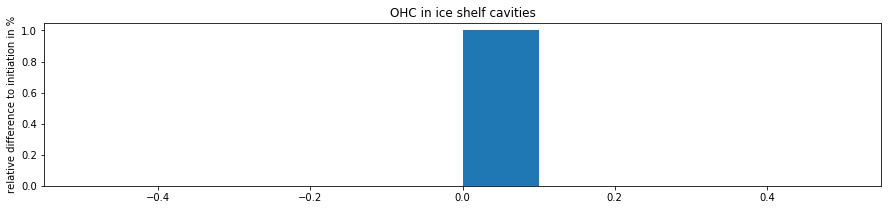

peak memory: 10855.61 MiB, increment: 0.00 MiB
CPU times: user 5.18 s, sys: 3.44 s, total: 8.61 s
Wall time: 7.81 s


In [14]:
%%time
plot_spin(ohc,mask_cavity,'OHC in ice shelf cavities')
%memit

In [ ]:
plot_spin(ke,mask_cavity,'KE in ice shelf cavities')
%memit

In [ ]:
plot_spin(ds.salt,mask_cavity,'AVG SALT in ice shelf cavities',weights_cavity,avg=True)
%memit

##  on shelf ocean
By selecting data above 1000m, south of 60S and under the cavity, I separate the for us interesting on shelf and slower spin up off shelf ocean. 

In [ ]:
# add the depth of each cell at each time to the data set
ds = make_4D_depth(ds)
ds['depth'] = ds.depth.mean('ocean_time')
#set up the mask (array of bolian values)
mask_shelf= (ds.lat_rho < -60) & (ds.depth > -1000) | (ds.zice < 0.0)
weights_shelf = ds.dV.where(mask_shelf)*rho/(ds.dV.where(mask_shelf)*rho).sum(dim=['s_rho','xi_rho','eta_rho'])
%memit

In [ ]:
#check up plots
plt.close()
weights.isel(s_rho = 0,ocean_time=0).plot()
plt.show()

In [ ]:
plot_spin(ohc,mask_shelf,'OHC on shelf')
%memit

In [ ]:
plot_spin(ke,mask_shelf,'KE on shelf')
%memit

In [ ]:
plot_spin(ds.salt,mask_shelf,'AVG SALT on shelf',weights_shelf,avg=True)
%memit

##  off shelf  and deep ocean

In [ ]:
mask_deep = ~mask_shelf
weights_deep = ds.dV.where(mask_deep)*rho/(ds.dV.where(mask_deep)*rho).sum(dim=['s_rho','xi_rho','eta_rho'])
%memit

In [ ]:
#check up plots
plt.close()
weights.isel(s_rho = 0,ocean_time=0).plot()
plt.show()

In [ ]:
plot_spin(ohc,mask_shelf,'OHC of shelf')
%memit

In [ ]:
plot_spin(ke,mask_shelf,'KE of shelf')
%memit

In [ ]:
plot_spin(ds.salt,mask_shelf,'AVG of shelf',weights_shelf,avg=True)
%memit